In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras
from keras.optimizers import Adam
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

/Users/Joonil/anaconda/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Read dataset

In [2]:
# Define attributes of u.item
FieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
      'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
      'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']

# Read the data into dataframes
DataDf = pd.read_csv("ml-100k/u.data", sep='\t', names=["user_id", "item_id", "rating", "timestamp"])
Itemdata = pd.read_csv("ml-100k/u.item", sep='|', encoding = "ISO-8859-1", names=FieldsMovies)

# Setups
FindID = Itemdata.movieTitle.to_dict()  # key: movieID-1, value:movie title
NumItems = len(DataDf.item_id.unique())
NumUsers = len(DataDf.user_id.unique())

In [3]:
DataDf = DataDf.drop('timestamp', axis=1)
DataDf.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
DataDf.describe()

,user_id,item_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


Let's see how many unique users and items (movies) in the dataset.

In [5]:
print("Number of Users: {}\nNumber of Movies: {}".format(NumUsers, NumItems))

Number of Users: 943
Number of Movies: 1682


### Train Test Split

In [6]:
train, test = train_test_split(DataDf, test_size=0.2)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Cosine Similarity

In [89]:
def buildItemUserMatrix(dataDf):
    '''
    Input
    - datadf: A pandas dataframe of movielens dataset

    Ouput
    - matrix: A 2d numpy array of Item-User Matrix (numItems x numUsers)
    '''
    dataMatrix = np.zeros((NumItems, NumUsers), dtype=np.int8)

    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating) in dataDf.itertuples():
        dataMatrix[itemID-1, userID-1] = rating
    return dataMatrix

def getSimilarMovies(similarity, movieID, k=5):
    '''
    Recommend k-number of similar movie by cosine similarity metric
    '''
    movieVec = similarity[movieID-1]
    movieVec = np.delete(movieVec, movieID-1)
    sortedIdx = np.argsort(movieVec)[::-1]
    print("Did you like '{}'?\n".format(FindID[movieID-1]))
    print("What we recommend for you")
    for i in range(k):
        movietitle = FindID[sortedIdx[i+1]+1]
        print("{}: {}".format(i+1, movietitle))

def whichMovie(movieID):
    return FindID[movieID-1]

def predictRatings(trainDf, similarity):
    '''
    Predict empty ratings by using item-cosine-similarity
    '''
    dataMatrix = buildItemUserMatrix(trainDf)
    predictionMatrix = np.zeros((NumItems, NumUsers))
    
    # loop over non-rated items
    for u in range(NumUsers):
        userVector = dataMatrix[:,u]
        nonzeros = userVector.nonzero()
        itemRatings = userVector[nonzeros]
        zeros = np.argwhere(userVector == 0).flatten()

        for i in zeros:
            # Get the similarity score for each of the items that provided rating by this user
            itemSims = similarity[i,:][nonzeros]

            if itemSims.sum() == 0:
                continue
            else:
                #Predict score based on item-item similarity
                predictionMatrix[i,u] = (itemRatings * itemSims).sum() / itemSims.sum()
    
    return predictionMatrix

def recommendMovies(userID, **options):
    '''
    Recommend movies for the user with userID
    '''
    # Read options args
    model = options.pop('model', None)
    trainDf = options.pop('train_data', None)
    similarity = options.pop('similarity', None)
    predictionMatrix = options.pop('prediction_matrix', None)
    k = options.pop('k', 10)
    
    if options:
        raise TypeError("Invalid parameters passed: %s" % str(options))

    
    
    recMovies = []
    
    # if trained model was passed in
    if model:
        pairs = [ np.array([userID] * NumUsers),
                 np.array([itemID for itemID in range(1, NumItems+1)]) ]
        pred = model.predict(pairs)
        argmaxIdx = np.argsort(pred, axis=0)[::-1].squeeze()
        argmaxIdx = argmaxIdx[:k]

        # Get the k-highest scored movies in the predictions list
        for i in argmaxIdx:
            recMovies.append(FindID[i])

        return recMovies
    
    # if similarity matrix was passed in, use cosine similarity
    elif similarity is not None:

        # if trainDf is None, raise error
        if trainDf is None:
            raise BaseException("Invalid data types passed")
        
        # if prediction matrix is None, calculate it
        if predictionMatrix is None:
            predictionMatrix = predictRatings(trainDf, similarity)
         
        userVector = predictionMatrix[:, userID-1]
        argmaxIdx = np.argsort(userVector, axis=0)[::-1].squeeze()
        
        if len(argmaxIdx) >= k:
            argmaxIdx = argmaxIdx[:k]
        
        # Get the k-highest scored movies in the predictions list
        for i in argmaxIdx:
            recMovies.append(FindID[i])

        return recMovies

def usersBestMovies(dataDf, userID):
    '''
    Find the best rated movies for the user
    '''
    # if the userID is not found in the data, print error message
    if len(dataDf.loc[dataDf['user_id'] == userID]) == 0:
        print("'User_ID {}' is not in our database!".format(userID))
        return
    
    # Return all the movies which were rated the highest score by the user
    maxrating = dataDf.loc[dataDf['user_id']==userID].rating.max()
    bestMovieIDs = dataDf.loc[(dataDf['user_id']==userID) &
                            (dataDf['rating']==maxrating)].item_id
    
    # Store the best movies
    bestMovies = []
    for movieID in bestMovieIDs:
        bestMovies.append(FindID[movieID-1])
        
    return bestMovies

In [16]:
dataMatrix = buildItemUserMatrix(DataDf)
similarity = cosine_similarity(dataMatrix)
trainMatrix = buildItemUserMatrix(train)
testMatrix = buildItemUserMatrix(test)
pred_Matrix = predictRatings(train, similarity)

In [46]:
# add predicted scores in the test dataframe
for ind, userID, itemID, rating in test.itertuples():
    test.loc[ind, 'pred_cosSim'] = pred_Matrix[itemID-1, userID-1]

rmse_similarity = np.sqrt(mean_squared_error(test.rating, test.pred_cosSim))
rmse_similarity_round = np.sqrt(mean_squared_error(test.rating, np.round(test.pred_cosSim)))
print("Root Mean Square Error {}".format(rmse_similarity))
print("Root Mean Square Error (rounded) {}".format(rmse_similarity_round))

Root Mean Square Error 1.010567440981017
Root Mean Square Error (rounded) 1.050951949424901


### Matrix Factorization Using Keras

In [48]:
# hyperparameters
n_latent_factors = 3

movie_input = keras.layers.Input(shape=[1], name='Item')
movie_embedding = keras.layers.Embedding(NumItems + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1], name='User')
user_embedding = keras.layers.Embedding(NumUsers + 1, n_latent_factors,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.dot([movie_vec, user_vec], axes=1, name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [49]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [50]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=1)

Epoch 1/100
80000/80000 [==============================] - 4s 47us/step - loss: 12.2668
Epoch 2/100
80000/80000 [==============================] - 4s 49us/step - loss: 4.7439
Epoch 3/100
80000/80000 [==============================] - 4s 52us/step - loss: 1.9624
Epoch 4/100
80000/80000 [==============================] - 4s 51us/step - loss: 1.3222
Epoch 5/100
80000/80000 [==============================] - 3s 41us/step - loss: 1.0867
Epoch 6/100
80000/80000 [==============================] - 3s 42us/step - loss: 0.9846
Epoch 7/100
80000/80000 [==============================] - 3s 40us/step - loss: 0.9360
Epoch 8/100
80000/80000 [==============================] - 3s 42us/step - loss: 0.9100
Epoch 9/100
80000/80000 [==============================] - 4s 46us/step - loss: 0.8952
Epoch 10/100
80000/80000 [==============================] - 3s 42us/step - loss: 0.8856
Epoch 11/100
80000/80000 [==============================] - 3s 37us/step - loss: 0.8791
Epoch 12/100
80000/80000 [==============

80000/80000 [==============================] - 5s 61us/step - loss: 0.7195
Epoch 95/100
80000/80000 [==============================] - 3s 43us/step - loss: 0.7192
Epoch 96/100
80000/80000 [==============================] - 4s 45us/step - loss: 0.7190
Epoch 97/100
80000/80000 [==============================] - 4s 52us/step - loss: 0.7187
Epoch 98/100
80000/80000 [==============================] - 3s 43us/step - loss: 0.7184
Epoch 99/100
80000/80000 [==============================] - 3s 41us/step - loss: 0.7181
Epoch 100/100
80000/80000 [==============================] - 3s 38us/step - loss: 0.7178


In [53]:
losshist = history.history['loss']

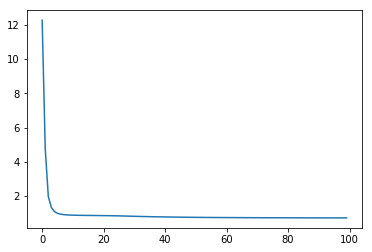

In [54]:
# Plot loss history
plt.plot(losshist)
plt.show()

In [55]:
y_pred = model.predict([test.user_id, test.item_id])
rmse_factorize = np.sqrt(mean_squared_error(test.rating, y_pred))
mae_factorize = np.sqrt(mean_absolute_error(test.rating, y_pred))
print("Root Mean Square Error {}".format(rmse_factorize))
print("Mean Absolute Error {}".format(mae_factorize))

Root Mean Square Error 0.9491449008978493
Mean Absolute Error 0.8592311690855685


Round up the predicted scores

In [56]:
rmse_factorize_round = np.sqrt(mean_squared_error(test.rating, np.round(y_pred)))
mae_factorize_round = np.sqrt(mean_absolute_error(test.rating, np.round(y_pred)))
print("Root Mean Square Error {}".format(rmse_factorize_round))
print("Mean Absolute Error {}".format(mae_factorize_round))

Root Mean Square Error 0.9925976022538036
Mean Absolute Error 0.8371081172704037


### Non-negative Matrix Factorization

In [57]:
from keras.constraints import non_neg
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(NumItems + 1, n_latent_factors, name='NonNegMovie-Embedding',
                                        embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(NumUsers + 1, n_latent_factors,name='NonNegUser-Embedding',
                                        embeddings_constraint=non_neg())(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.dot([movie_vec, user_vec], axes=1, name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [59]:
history_nonneg = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=1)

Epoch 1/100
80000/80000 [==============================] - 4s 45us/step - loss: 0.7195
Epoch 2/100
80000/80000 [==============================] - 4s 47us/step - loss: 0.7186
Epoch 3/100
80000/80000 [==============================] - 4s 46us/step - loss: 0.7185
Epoch 4/100
80000/80000 [==============================] - 4s 47us/step - loss: 0.7183
Epoch 5/100
80000/80000 [==============================] - 4s 46us/step - loss: 0.7178
Epoch 6/100
80000/80000 [==============================] - 4s 47us/step - loss: 0.7180
Epoch 7/100
80000/80000 [==============================] - 4s 54us/step - loss: 0.7177
Epoch 8/100
80000/80000 [==============================] - 5s 64us/step - loss: 0.7174
Epoch 9/100
80000/80000 [==============================] - 4s 56us/step - loss: 0.7174
Epoch 10/100
80000/80000 [==============================] - 4s 54us/step - loss: 0.7174
Epoch 11/100
80000/80000 [==============================] - 4s 51us/step - loss: 0.7170
Epoch 12/100
80000/80000 [===============

80000/80000 [==============================] - 4s 50us/step - loss: 0.7114
Epoch 95/100
80000/80000 [==============================] - 4s 48us/step - loss: 0.7114
Epoch 96/100
80000/80000 [==============================] - 4s 49us/step - loss: 0.7114
Epoch 97/100
80000/80000 [==============================] - 4s 48us/step - loss: 0.7114
Epoch 98/100
80000/80000 [==============================] - 4s 48us/step - loss: 0.7114
Epoch 99/100
80000/80000 [==============================] - 4s 50us/step - loss: 0.7114
Epoch 100/100
80000/80000 [==============================] - 5s 68us/step - loss: 0.7111


In [70]:
y_pred_nonneg = model.predict([test.user_id, test.item_id])
rmse_factorize = np.sqrt(mean_squared_error(test.rating, y_pred_nonneg))
rmse_factorize_nonneg = np.sqrt(mean_squared_error(test.rating, np.round(y_pred_nonneg)))

# Print out the RMSE
print("Root Mean Square Error {}".format(rmse_factorize))
print("Root Mean Square Error (rounded) {}".format(rmse_factorize_nonneg))

Root Mean Square Error 0.9506555924150177
Root Mean Square Error (rounded) 0.9958664569107647


In [71]:
test = test.assign(pred_Factorization=np.round(y_pred))

In [72]:
test.head()

,user_id,item_id,rating,pred_cosSim,prediction_Factorization
0,405,181,5,2.266420,3.0
1,857,892,3,3.032868,2.0
2,851,693,5,3.829329,4.0
3,468,1016,3,3.960365,3.0
4,625,22,3,3.564295,4.0


In [81]:
trainBest = usersBestMovies(train, 1)
testBest = usersBestMovies(test, 1)
predBest_cossim = recommendMovies(1, train_data=train, similarity=similarity, prediction_matrix=pred_Matrix)
predBest_factor = recommendMovies(1, model=model)

In [82]:
trainBest

['When Harry Met Sally... (1989)',
 'Lone Star (1996)',
 'Welcome to the Dollhouse (1995)',
 'French Twist (Gazon maudit) (1995)',
 'Haunted World of Edward D. Wood Jr., The (1995)',
 'Mystery Science Theater 3000: The Movie (1996)',
 'Wrong Trousers, The (1993)',
 'Bound (1996)',
 'Jean de Florette (1986)',
 'Mars Attacks! (1996)',
 'Good, The Bad and The Ugly, The (1966)',
 'Professional, The (1994)',
 "Monty Python's Life of Brian (1979)",
 'Crumb (1994)',
 '12 Angry Men (1957)',
 'Princess Bride, The (1987)',
 'Star Wars (1977)',
 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Henry V (1989)',
 'Chasing Amy (1997)',
 'Graduate, The (1967)',
 'Dolores Claiborne (1994)',
 'Ridicule (1996)',
 'Three Colors: Blue (1993)',
 'Priest (1994)',
 'Big Night (1996)',
 'Eat Drink Man Woman (1994)',
 'Return of the Jedi (1983)',
 'Three Colors: Red (1994)',
 'Chasing Amy (1997)',
 'Clerks (1994)',
 'Empire Strikes Back, The (1980)',
 'Nikita (La Femme Nikita) (1990)',
 'Pillow Book

In [84]:
testBest

['Searching for Bobby Fischer (1993)',
 'Truth About Cats & Dogs, The (1996)',
 'Shawshank Redemption, The (1994)',
 'Amadeus (1984)',
 'Blade Runner (1982)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Postino, Il (1994)',
 'Maya Lin: A Strong Clear Vision (1994)',
 'Delicatessen (1991)',
 'Raiders of the Lost Ark (1981)',
 'Remains of the Day, The (1993)',
 'Fargo (1996)',
 'Full Monty, The (1997)',
 'Cinema Paradiso (1988)',
 'Usual Suspects, The (1995)',
 'Sling Blade (1996)']

In [86]:
predBest_cossim

['Cyclo (1995)',
 'Little City (1998)',
 'Coldblooded (1995)',
 'Mamma Roma (1962)',
 'King of New York (1990)',
 'Office Killer (1997)',
 'Substance of Fire, The (1996)',
 'Ballad of Narayama, The (Narayama Bushiko) (1958)',
 "C'est arrivé près de chez vous (1992)",
 "My Life and Times With Antonin Artaud (En compagnie d'Antonin Artaud) (1993)"]

In [87]:
predBest_factor

['Two or Three Things I Know About Her (1966)',
 'In the Line of Duty 2 (1987)',
 'Great Day in Harlem, A (1994)',
 'Maya Lin: A Strong Clear Vision (1994)',
 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Love and Death on Long Island (1997)',
 'Godfather, The (1972)',
 'High Noon (1952)',
 'Godfather: Part II, The (1974)',
 'Laura (1944)']

## Recommend movies by using different systems

#### 1. Cosine Similarity

In [ ]:
recommendMovies(userID=1, train_data=train, similarity=similarity,
                prediction_matrix=pred_Matrix)

#### 2. Matrix Factorization

#### 3. Non-negative Matrix Factorization